In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
import warnings
warnings.simplefilter('ignore')

- Submission_1 : Single XGB with random state 0 with SMOTE
- Submission_2 : Combination of 5 XGB and 5 Random Forest with Random state 0 with SMOTE
- Submission_3 : Combination of 5 Random Forest with Random state 0 with SMOTE
- Submission_4 : Submission 3 with Annual Income Dropped
- Submission_5 : Submission 2 with Annual Income Dropped
- Submission_6 : Submission 3 with Annual Income, Stay Duration of Current Residence and Tenure of Oldest Credit Line Dropped and random states 10 everywhere

In [2]:
train = pd.read_csv('TrainingData.csv')
test = pd.read_csv('testX.csv')

df = pd.concat([train, test], axis = 0)

df.shape

(130000, 53)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130000 entries, 0 to 46999
Data columns (total 53 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   application_key  130000 non-null  int64  
 1   mvar1            130000 non-null  object 
 2   mvar2            120787 non-null  float64
 3   mvar3            129171 non-null  float64
 4   mvar4            129171 non-null  float64
 5   mvar5            129171 non-null  float64
 6   mvar6            130000 non-null  object 
 7   mvar7            130000 non-null  object 
 8   mvar8            130000 non-null  object 
 9   mvar9            130000 non-null  object 
 10  mvar10           130000 non-null  object 
 11  mvar11           130000 non-null  object 
 12  mvar12           130000 non-null  object 
 13  mvar13           130000 non-null  object 
 14  mvar14           130000 non-null  int64  
 15  mvar15           130000 non-null  object 
 16  mvar16           130000 non-null  objec

In [4]:
columns = ['ID',
           'Credit Worthiness Score',
           'Number and Riskiness of Credit Enquiry',
           'Default Severity (Any Loan)',
           'Default Severity (Auto Loan)',
           'Default Severity (Education Loan)',
           'Min Cred Available (Revolving Credit Cards)',
           'Max Cred Available (Active Credit Lines)',
           'Max Cred Available (Active Revolving Credit Cards)',
           'Total Available Credit (Cards with 1 missed payment)',
           'Total Credit Available',
           'Dues Collected Post Default',
           'Total Amount Due (Active Cards)',
           'Credit Amount Paid (Prev Year)',
           'Annual Income',
           'Property Value',
           'Full Credit Utilisation (Revolving Credit Cards)',
           'Full Credit Utilisation (Credit Cards)',
           'Full Credit Utilisation (Credit Lines)',
           '>75 percent Credit Utilisation (Credit Cards)',
           '>75 percent Credit Utilisation (Credit Lines)',
           'Average Utilisation (Revolving Credit Cards)',
           'Average Utilisation Last 2 Years (All Credit Lines)',
           'Average Utilisation Last Year (All Credit Cards)',
           'Average Utilisation Last 6 Months with 1 Missed Payment (Credit Cards)',
           'Average Tenure (Active Revolving Credit Cards)',
           'Tenure of Oldest Active Credit Card',
           'Tenure of Oldest Active Revolving Credit Card',
           'Days Since Last Missed Payment',
           'Tenure of Oldest Credit Line',
           'Max Tenure (Auto Loans)',
           'Max Tenure (Education Loans)',
           'Sum of Tenures (Active Credit Cards)',
           'Stay Duration of Current Residence',
           'Credit Lines with 1 Missed Payment (Last 6 Months)',
           'Revolving Credit Cards with 1 Missed Payment (Last 2 Years)',
           'Active Credit Lines',
           'Credit Cards with >2Y Tenure',
           'Credit Lines activated Prev 2 Years',
           'Credit Lines with Current Delinquency',
           'Utilization on Active Education Loans',
           'Utilization on Active Auto Loans',
           'Financial Stress Index',
           'Credit Lines with No Missed Payments (Prev 2 Years)',
           'Ratio(Max Amount Due : Sum of Amounts Due)',
           'Mortgage Loans (With 2 Missed Payements)',
           'Auto Loans (With 2 Missed Payments)',
           'Type of Product',
           'Int Value for an Application',
           'Bucketized Credit Worthiness Score',
           'Compound of mvar49 and mvar48',
           'mvar51',
           'default_ind']

In [5]:
df.columns = columns

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130000 entries, 0 to 46999
Data columns (total 53 columns):
 #   Column                                                                  Non-Null Count   Dtype  
---  ------                                                                  --------------   -----  
 0   ID                                                                      130000 non-null  int64  
 1   Credit Worthiness Score                                                 130000 non-null  object 
 2   Number and Riskiness of Credit Enquiry                                  120787 non-null  float64
 3   Default Severity (Any Loan)                                             129171 non-null  float64
 4   Default Severity (Auto Loan)                                            129171 non-null  float64
 5   Default Severity (Education Loan)                                       129171 non-null  float64
 6   Min Cred Available (Revolving Credit Cards)                          

### Feature Understanding (Explanations and Stuff to Look into)

- Auto Loans: Loans where Vehicles are kept as collateral
- Revolving Credit: You have a fixed amount that you can borrow in some fixed time frame. After that the amount you can borrow replenishes to the full amount. Although you will have a maximum limit. For example, you can borrow 100 rupees a month max and the overall limit on that credit line is 500 rupees. So if your overall borrowed amount is 460 rupees and for that month you havenn't borrowed anything so far, you will be able to borrow only 40 rupees even though the monthly limit is 100
- Difference between Credit Worthiness Score and its bucketized version?
- Difference in statistics between train and test (Need for Adverserial Validation?)

### Feature Ideas and Experiments
- Binary Variable for checking if the person has moved into current residence after issuing any credit lines
- Credit Amount Paid / Number of Credit Lines with No Missed Payments
- Max Cred Available vs Default Severity
- Separate modeling for 0 Default Severity vs Non-Zero Default Severity
- KNN Missing Values Fill In
- Property Value vs Annual Income (Some Indicator of whether or not a person spends too much for their Income)
- 75% utilisation / Full Utilisation

In [7]:
df.head(10)

,ID,Credit Worthiness Score,Number and Riskiness of Credit Enquiry,Default Severity (Any Loan),Default Severity (Auto Loan),Default Severity (Education Loan),Min Cred Available (Revolving Credit Cards),Max Cred Available (Active Credit Lines),Max Cred Available (Active Revolving Credit Cards),Total Available Credit (Cards with 1 missed payment),Total Credit Available,Dues Collected Post Default,Total Amount Due (Active Cards),Credit Amount Paid (Prev Year),Annual Income,Property Value,Full Credit Utilisation (Revolving Credit Cards),Full Credit Utilisation (Credit Cards),Full Credit Utilisation (Credit Lines),>75 percent Credit Utilisation (Credit Cards),>75 percent Credit Utilisation (Credit Lines),Average Utilisation (Revolving Credit Cards),Average Utilisation Last 2 Years (All Credit Lines),Average Utilisation Last Year (All Credit Cards),Average Utilisation Last 6 Months with 1 Missed Payment (Credit Cards),Average Tenure (Active Revolving Credit Cards),Tenure of Oldest Active Credit Card,Tenure of Oldest Active Revolving Credit Card,Days Since Last Missed Payment,Tenure of Oldest Credit Line,Max Tenure (Auto Loans),Max Tenure (Education Loans),Sum of Tenures (Active Credit Cards),Stay Duration of Current Residence,Credit Lines with 1 Missed Payment (Last 6 Months),Revolving Credit Cards with 1 Missed Payment (Last 2 Years),Active Credit Lines,Credit Cards with >2Y Tenure,Credit Lines activated Prev 2 Years,Credit Lines with Current Delinquency,Utilization on Active Education Loans,Utilization on Active Auto Loans,Financial Stress Index,Credit Lines with No Missed Payments (Prev 2 Years),Ratio(Max Amount Due : Sum of Amounts Due),Mortgage Loans (With 2 Missed Payements),Auto Loans (With 2 Missed Payments),Type of Product,Int Value for an Application,Bucketized Credit Worthiness Score,Compound of mvar49 and mvar48,mvar51,default_ind
0,230032,1696,1.6541,0.000,0.0,0.0,0,6015,322,40369,18414,missing,6423,3067,123875,missing,1,1,1,3,3,94.78,8987.18,NaN,72.25,1462,4532,2890,61,4532,1095,3376,625,1.1667,1,0,8,10,4,1,73.78,82.547,0.08696,10,0.63899,na,0,C,10,770,4,3080,0.0
1,230033,1846,0.8095,0.000,0.0,0.0,102,7532,3171,18234,13664,missing,765,1931,42613,missing,0,0,0,0,0,74.25,953.06,953.06,4.80,1028,2099,2099,30386,2281,missing,2251,169,0.4167,0,0,8,0,2,0,99.129,missing,0,13,0.63836,na,na,L,732,437,5,2185,1.0
2,230034,1745,0.4001,0.000,0.0,0.0,missing,2536,missing,missing,2536,missing,missing,missing,76109,missing,na,na,na,0,0,NaN,NaN,NaN,NaN,missing,missing,missing,669,4623,3772,missing,missing,25.0833,0,na,1,na,1,0,missing,29.29,0,1,1.00000,na,0,C,89,795,4,3180,1.0
3,230035,1739,0.2193,0.000,0.0,0.0,1982,26440,4955,20316,37013,missing,0,0,84235,missing,0,0,0,0,0,NaN,0.00,NaN,0.00,1308,2525,791,91,5992,missing,3741,215,10.3333,0,0,3,3,2,0,96.272,missing,0.15385,3,0.53241,0,0,L,3,755,4,3020,0.0
4,230036,1787,0.0118,0.225,0.0,0.0,5451,5494,5494,7987,4696,missing,2257,27815,123875,524848,0,0,0,0,0,20.51,796.67,NaN,28.72,801,2281,2281,487,2707,missing,1947,158,0.9167,0,0,2,3,2,0,115.019,missing,0,1,0.92665,na,na,L,5,425,4,1700,0.0
5,230037,1579,NaN,3.502,0.0,0.0,missing,missing,missing,missing,0,199,missing,missing,77298,missing,na,na,na,0,0,NaN,NaN,NaN,NaN,missing,missing,missing,183,973,missing,missing,missing,1.3333,0,na,2,na,2,na,missing,missing,1.5,0,NaN,na,na,C,35,455,4,1820,1.0
6,230038,1818,0.4001,0.000,0.0,0.0,missing,1088,missing,1536,1498,missing,448,2331,123875,missing,na,0,0,0,0,NaN,NaN,NaN,29.16,1034,760,missing,30386,3437,missing,791,34,9.3333,0,na,2,0,0,0,88.171,missing,0,2,0.87224,na,0,C,2,392,5,1960,1.0
7,230039,na,NaN,NaN,NaN,NaN,missing,missing,missing,missing,missing,missing,missing,missing,198200,1263525,na,na,na,0,na,NaN,NaN,NaN,NaN,missing,missing,missing,missing,missing,missing,missing,missing,0.0833,na,na,na,na,na,na,missing,missing,missing,na,NaN,na,na,C,2,615,#VALUE!,#VALUE!,0.0
8,230040,1836,0.1358,0.000,0.0,0.0,347,38964,17828,70729,65843,missing,16298,18877,109010,missing,0,0,0,1,1,32.02,0.00,0.00,

In [8]:
df.replace('missing', np.nan, inplace = True)
df.replace('na', np.nan, inplace = True)
df.replace('#VALUE!', np.nan, inplace = True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130000 entries, 0 to 46999
Data columns (total 53 columns):
 #   Column                                                                  Non-Null Count   Dtype  
---  ------                                                                  --------------   -----  
 0   ID                                                                      130000 non-null  int64  
 1   Credit Worthiness Score                                                 124039 non-null  object 
 2   Number and Riskiness of Credit Enquiry                                  120787 non-null  float64
 3   Default Severity (Any Loan)                                             129171 non-null  float64
 4   Default Severity (Auto Loan)                                            129171 non-null  float64
 5   Default Severity (Education Loan)                                       129171 non-null  float64
 6   Min Cred Available (Revolving Credit Cards)                          

In [10]:
df.isnull().sum() * 100 / len(df)

ID                                                                         0.000000
Credit Worthiness Score                                                    4.585385
Number and Riskiness of Credit Enquiry                                     7.086923
Default Severity (Any Loan)                                                0.637692
Default Severity (Auto Loan)                                               0.637692
Default Severity (Education Loan)                                          0.637692
Min Cred Available (Revolving Credit Cards)                               23.844615
Max Cred Available (Active Credit Lines)                                   9.348462
Max Cred Available (Active Revolving Credit Cards)                        23.854615
Total Available Credit (Cards with 1 missed payment)                      14.226154
Total Credit Available                                                     0.638462
Dues Collected Post Default                                               56

In [11]:
df['Type of Product'].value_counts()

C    82535
L    47465
Name: Type of Product, dtype: int64

In [12]:
df.reset_index(drop = True, inplace = True)

In [13]:
def convert_to_int(entry):
    return float(entry)

for col in df.columns:
    if col not in ['Type of Product', 'default_ind']:
        df[col] = df[col].apply(convert_to_int)
    
df['Credit Worthiness Score'][0]

1696.0

In [14]:
df.fillna(-1, inplace = True)

In [15]:
df['default_ind'].value_counts()

 0.0    59145
-1.0    47000
 1.0    23855
Name: default_ind, dtype: int64

In [16]:
le = LabelEncoder()
df['Type of Product'] = le.fit_transform(df['Type of Product'])

In [17]:
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

, 'AnnualIncome', 'StayDurationofCurrentResidence', 'TenureofOldestCreditLine',
             'NumberandRiskinessofCreditEnquiry', 'CreditAmountPaidPrevYear', 'BucketizedCreditWorthinessScore',
             'mvar51', 'MaxTenureEducationLoans', 'PropertyValue'

In [18]:
train = df.iloc[:83000, :]

drop_cols = ['ID', 'default_ind']

X_data = train.drop(drop_cols, axis = 1)
y_data = train['default_ind']

In [19]:
train['TypeofProduct'].value_counts()

0    52043
1    30957
Name: TypeofProduct, dtype: int64

In [20]:
train[train['TypeofProduct'] == 0]['default_ind'].value_counts()

0.0    33217
1.0    18826
Name: default_ind, dtype: int64

In [21]:
train[train['TypeofProduct'] == 1]['default_ind'].value_counts()

0.0    25928
1.0     5029
Name: default_ind, dtype: int64

Best Parameters: {'n_estimators': 180, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 32, 'criterion': 'gini'}

In [22]:
kfold = StratifiedKFold(random_state = 10, n_splits = 5, shuffle = True)
splits = kfold.split(X_data, y_data)

sm = SMOTE(random_state = 10, k_neighbors = 7, n_jobs = -1)

cat1_acc_scores = []
cat1_f1_scores = []
cat1_models = []

cat2_acc_scores = []
cat2_f1_scores = []
cat2_models = []

i=1

for Train, Test in splits:
    X_Train, X_Test, Y_Train, Y_Test = X_data.iloc[Train], X_data.iloc[Test], y_data.iloc[Train], y_data.iloc[Test]
    
    cat1 = CatBoostClassifier(n_estimators = 10000, max_depth = 8, eval_metric = 'CrossEntropy',
                             bootstrap_type='Bernoulli',
                        learning_rate = 0.01, random_state = 0, early_stopping_rounds = 1000,
                        scale_pos_weight = 59145/23855)
    
    #rf = RandomForestClassifier(n_estimators = 130, max_depth=8, oob_score = True,
    #                            class_weight = 'balanced_subsample', n_jobs=-1,
    #                            random_state=10)
    #X_Train, Y_Train = sm.fit_resample(X_Train, Y_Train)
    
    cat1.fit(X_Train, Y_Train, eval_set = [(X_Train, Y_Train), (X_Test, Y_Test)], verbose = False)
    
    pred = cat1.predict(X_Test)
    
    cat1_f1_scores.append(f1_score(Y_Test, pred))
    cat1_acc_scores.append(accuracy_score(Y_Test, pred)*100)
    cat1_models.append(cat1)
    
    
    print("Iteration {} Completed".format(i))
    i+=1

Iteration 1 Completed
Iteration 2 Completed
Iteration 3 Completed
Iteration 4 Completed
Iteration 5 Completed


In [23]:
print("XGB F1 Score: ", sum(cat1_f1_scores)/len(cat1_f1_scores))
print("XGB Accuracy: ", sum(cat1_acc_scores)/len(cat1_acc_scores), "%")
#print("RF F1 Score: ", sum(rf_f1_scores)/len(rf_f1_scores))
#print("RF Accuracy: ", sum(rf_acc_scores)/len(rf_acc_scores), "%")

XGB F1 Score:  0.5961614836167051
XGB Accuracy:  73.15903614457831 %


Text(0.5, 1.0, 'Feature Importance')

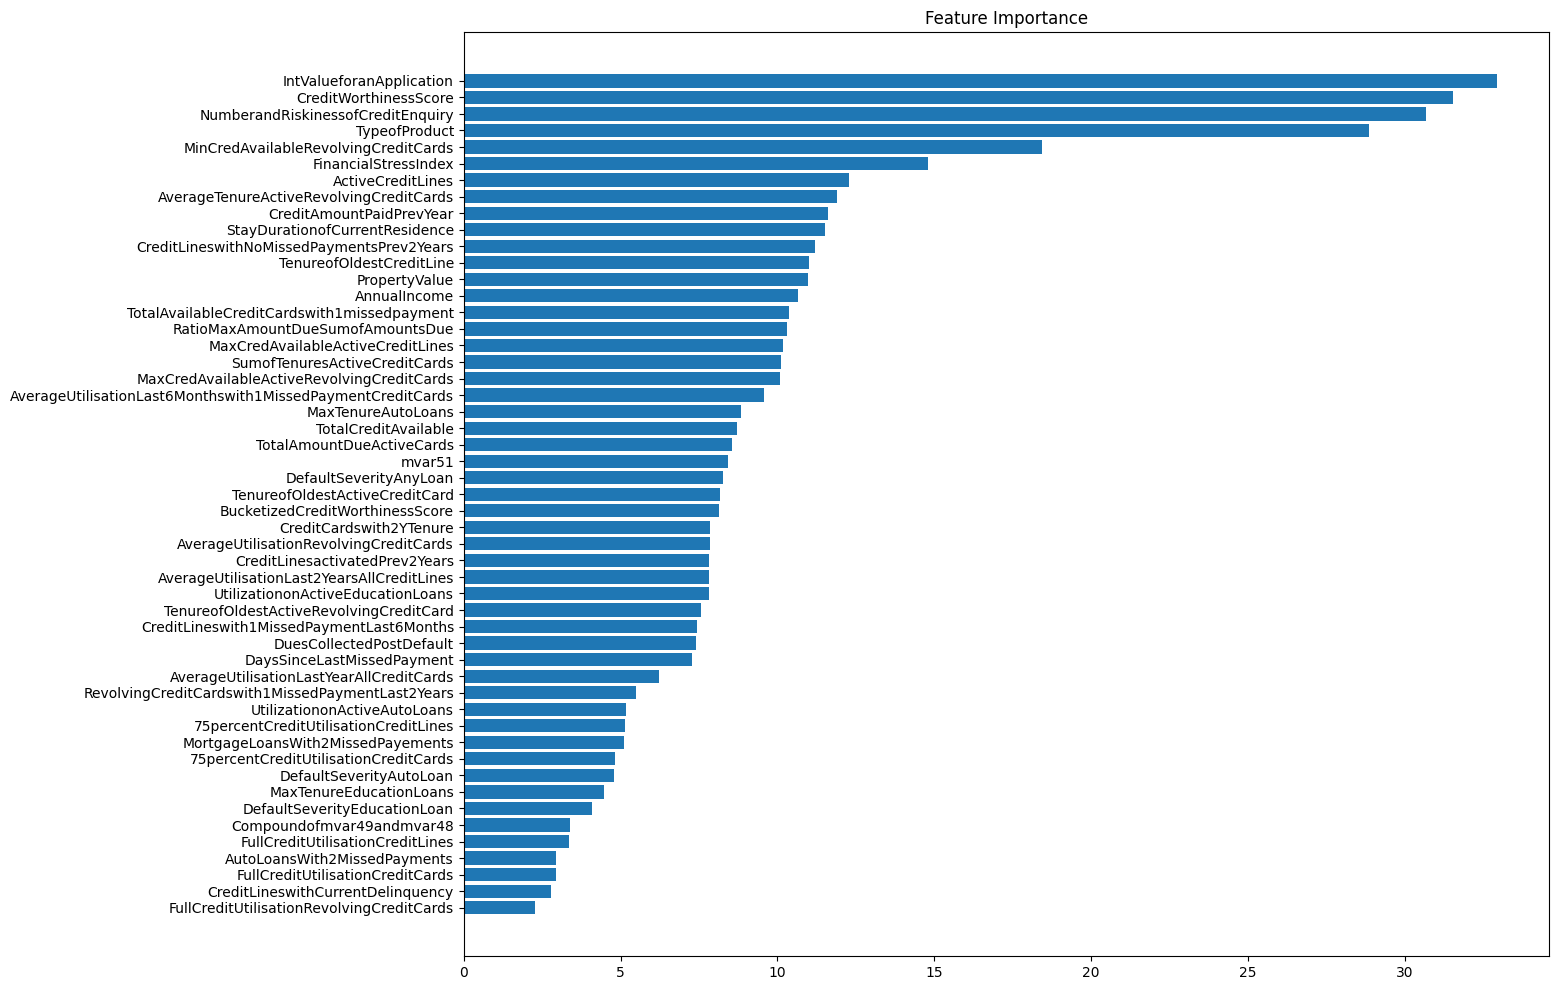

In [33]:
feature_importance = [cat1_models[0].feature_importances_ +
                      cat1_models[1].feature_importances_ +
                      cat1_models[2].feature_importances_ +
                      cat1_models[3].feature_importances_ +
                      cat1_models[4].feature_importances_]
sorted_idx = np.argsort(feature_importance[0])
fig = plt.figure(figsize=(14, 12))
plt.barh(range(len(sorted_idx)), feature_importance[0][sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_data.columns)[sorted_idx])
plt.title('Feature Importance')

In [ ]:
'''
0.59616
SMOTE neighbours = 5
xgb = CatBoostClassifier(n_estimators = 10000, max_depth = 8, eval_metric = 'CrossEntropy',
                             bootstrap_type='Bernoulli',
                        learning_rate = 0.01, random_state = 0, early_stopping_rounds = 1000,
                        scale_pos_weight = 59145/23855)

Bayesian/MVS- 0.59497
Bernoulli - 0.59616

model = xgb_models[0]

plt.figure(figsize = (10,10))
plot_importance(model, max_num_features = 5)
plt.show()'''

In [33]:
test = df.iloc[83000:, :]
test = test.drop(drop_cols, axis = 1)

In [34]:
preds = np.argmax(cat1_models[0].predict_proba(test) +
                  cat1_models[1].predict_proba(test) +
                  cat1_models[2].predict_proba(test) +
                  cat1_models[3].predict_proba(test) +
                  cat1_models[4].predict_proba(test),
                  #rf_models[0].predict_proba(test) +
                  #rf_models[1].predict_proba(test) +
                  #rf_models[2].predict_proba(test) +
                  #rf_models[3].predict_proba(test) +
                  #rf_models[4].predict_proba(test),
                  axis = 1)

In [35]:
#preds = best_clf_rf.best_estimator_.predict(test)

In [36]:
sample = pd.read_csv('submission.csv', header = None)
sample.head()

,0,1
0,578069,0
1,578070,1
2,578071,1
3,578072,1
4,578073,0


In [37]:
sample[1] = preds
sample.head()

,0,1
0,578069,0
1,578070,0
2,578071,0
3,578072,1
4,578073,0


In [38]:
sample[1].value_counts()

0    28549
1    18451
Name: 1, dtype: int64

In [39]:
#sample.to_csv('Submissions/ThirdDegreeBurn_14.csv', index = False, header=False)